In [1]:
cd

/Users/keith_tetrad


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import FlowCal
import flowutils
import os
import matplotlib.ticker as mtick
from matplotlib.patches import Patch
from scipy.stats import mannwhitneyu

In [3]:
# Logicle transform (linear near 0, log for the rest)

def logicle_transform(df, column_name):
    transformed_array = np.array(df[column_name]) 
    transformed_array = flowutils.transforms.logicle(transformed_array, None)
    df[column_name] = transformed_array
    return df

In [4]:
# def process_fcs_file(filepath):
#     # Ensure the file exists
#     if not os.path.exists(filepath):
#         print("File not found:", filepath)
#         return None

#     # Read and transform the FCS data
#     fcs_data = FlowCal.io.FCSData(filepath)
#     fcs_data = FlowCal.transform.to_rfi(fcs_data)

#     # Extract the sample_name from the filename
#     sample_name = "_".join(os.path.basename(filepath).split("_")[1:3])

#     # Add the identifier
#     identifier = np.full(shape=(fcs_data.shape[0], 1), fill_value=sample_name)
#     combined_data = np.hstack((fcs_data, identifier))

#     # Convert to DataFrame
#     combined_data_df = pd.DataFrame(combined_data, columns=list(fcs_data.channels) + ["sample_name"])
#     combined_data_df.iloc[:, :-1] = combined_data_df.iloc[:, :-1].apply(pd.to_numeric)

#     # Apply logicle transformation
#     combined_data_df = logicle_transform(combined_data_df, "530_30 Blue B-A")
#     combined_data_df = logicle_transform(combined_data_df, "610_20 YG D-A")

#     return combined_data_df

# def add_files_to_dict(directory):
#     files_dict = {}
#     for file in os.listdir(directory):
#         if file.endswith(".fcs"):  # Checking if the file is an FCS file
#             filepath = os.path.join(directory, file)
#             sample_name = "_".join(file.split("_")[1:3])  # Extract 'sample_name' from filename
#             processed_file = process_fcs_file(filepath)

#             # Check if the processed file has more than 5000 rows
#             if processed_file.shape[0] > 5000:
#                 files_dict[sample_name] = processed_file

#     return files_dict

# directory = 'UPR_drug_spike_expression/data/20231220 FlowJo'
# files_dictionary = add_files_to_dict(directory)
# files_dictionary = dict(sorted(files_dictionary.items(), key=lambda item: int(item[0].split('_')[1])))
# # Now files_dictionary contains only the processed data with more than 5000 rows, with codes as keys


# MetaData = pd.read_csv('UPR_drug_spike_expression/data/20231214_metadata.csv')

# combined_data_dict = {}

# for key, df in files_dictionary.items():
#     combined_data = pd.merge(df, MetaData, on="sample_name")
#     combined_data = combined_data.rename(columns={"530_30 Blue B-A": "FITC (a.u.)"})
#     combined_data = combined_data.rename(columns={"610_20 YG D-A": "mCherry (a.u.)"})
#     combined_data['Normalized (a.u.)'] = combined_data['FITC (a.u.)']-combined_data['mCherry (a.u.)']
#     combined_data_dict[key] = combined_data
       

In [5]:
# # Initialize an empty DataFrame to store aggregated statistics for each sample.
# # The DataFrame will include median and standard error of the mean (SEM) for mCherry and FITC signals.
# summary_df = pd.DataFrame(columns=[
#     'sample_name', 'cell_line', 'drug', 'secondary',
#     'median_mCherry', 'sem_mCherry', 'median_FITC', 'sem_FITC'
# ])

# # Process and aggregate data from each sample DataFrame stored in combined_data_dict.
# for df in combined_data_dict.values():
#     # Calculate median values and SEM for mCherry and FITC signals.
#     df['median_mCherry'] = df['mCherry (a.u.)'].median()
#     df['sem_mCherry'] = df['mCherry (a.u.)'].sem()  # SEM for mCherry
#     df['median_FITC'] = df['FITC (a.u.)'].median()
#     df['sem_FITC'] = df['FITC (a.u.)'].sem()  # SEM for FITC

#     # Select relevant columns and remove duplicate entries.
#     selected_columns = df[['sample_name', 'cell_line', 'drug', 'secondary', 
#                            'median_mCherry', 'sem_mCherry', 'median_FITC', 'sem_FITC']].drop_duplicates()

#     # Append these columns to the summary DataFrame for a comprehensive summary.
#     summary_df = pd.concat([summary_df, selected_columns], ignore_index=True)

# # Filter out samples marked as 'unlabel' in the 'secondary' column.
# summary_df = summary_df[summary_df['secondary'] != 'unlabel']
    
# # Function to calculate a weighted mean for aggregating data points.
# # This function helps in finding the average when data points have associated weights (importance or reliability).
# def weighted_mean(values, weights):
#     return np.average(values, weights=weights)

# # Function to calculate a combined standard deviation across different groups of data.
# # This function is useful for finding an overall measure of variability when you have data from multiple groups.
# def combined_std(stds, means, weights):
#     weighted_variances = [w**2 * v**2 for w, v in zip(weights, stds)]  # Calculate weighted variance for each group
#     sum_weighted_variances = np.sum(weighted_variances)  # Sum up all the weighted variances
#     return np.sqrt(sum_weighted_variances / np.sum(weights))  # The square root gives the combined standard deviation

# # Group the summary DataFrame by 'cell_line', 'drug', and 'secondary' for aggregation.
# grouped = summary_df.groupby(['cell_line', 'drug', 'secondary'])

# # Calculate the weighted mean and combined standard deviation for each group.
# # This creates a compressed DataFrame with aggregated statistics for each group.
# compressed_df = grouped.apply(lambda x: pd.Series({
#     'median_mCherry': weighted_mean(x['median_mCherry'], 1/x['sem_mCherry']),
#     'sem_mCherry': combined_std(x['sem_mCherry'], x['median_mCherry'], 1/x['sem_mCherry']),
#     'median_FITC': weighted_mean(x['median_FITC'], 1/x['sem_FITC']),
#     'sem_FITC': combined_std(x['sem_FITC'], x['median_FITC'], 1/x['sem_FITC'])
# })).reset_index()

# # Function to normalize FITC to mCherry ratios to a control drug.
# # This normalization is crucial for comparing results across different treatments or conditions.
# def normalize_to_control(df, control_drug='DMSO'):
#     # Calculate the ratio of FITC to mCherry for each sample and its error.
#     df['FITC_mCherry_ratio'] = df['median_FITC'] / df['median_mCherry']
#     df['error_ratio'] = df['FITC_mCherry_ratio'] * np.sqrt(
#         (df['sem_FITC'] / df['median_FITC'])**2 + 
#         (df['sem_mCherry'] / df['median_mCherry'])**2
#     )

#     # Extract control ratios for each cell line to use in normalization.
#     control_ratios = df[df['drug'] == control_drug][['cell_line', 'FITC_mCherry_ratio', 'error_ratio']]

#     # Merge the control data with the main DataFrame for direct comparison.
#     normalized_df = df.merge(control_ratios, 
#                              on='cell_line', 
#                              suffixes=('', '_control'))

#     # Calculate the normalized ratio to control and its associated error.
#     normalized_df['normalized_to_control'] = normalized_df['FITC_mCherry_ratio'] / normalized_df['FITC_mCherry_ratio_control']
#     normalized_df['error_normalized_to_control'] = normalized_df['normalized_to_control'] * np.sqrt(
#         (normalized_df['error_ratio'] / normalized_df['FITC_mCherry_ratio'])**2 + 
#         (normalized_df['error_ratio_control'] / normalized_df['FITC_mCherry_ratio_control'])**2
#     )

#     return normalized_df

# # Apply the normalization function to the aggregated data.
# normalized_data = normalize_to_control(compressed_df, control_drug='DMSO')


In [6]:
# def plot_kde_fitc_by_drug_secondary(data_dict, cell_line_label,antibody):
#     plt.figure(figsize=(15, 10))

#     # Define a color palette for the drugs
#     drug_colors = {'DMSO': 'blue', '4u8c': 'green', 'C7': 'red', 'Both': 'purple'}

#     for key, df in data_dict.items():
#         # Filter for 'cell_line' label
#         filtered_df = df[df['cell_line'] == cell_line_label]

#         if not filtered_df.empty:
#             for drug in drug_colors.keys():
#                 drug_df = filtered_df[filtered_df['drug'] == drug]
#                 for secondary_label in drug_df['secondary'].unique():
#                     sec_df = drug_df[drug_df['secondary'] == secondary_label]
#                     if not sec_df.empty:
#                         label = f'{key} - {drug} - {secondary_label}'
#                         linestyle = '--' if secondary_label == 'unlabel' else '-'
#                         sns.kdeplot(data=sec_df, x=antibody, label=label, 
#                                     fill=False, color=drug_colors[drug], linestyle=linestyle)
                        
#     plt.xlabel('FITC/mCherry (a.u.)')
#     plt.ylabel('Density')
#     plt.title('FITC Signal Density by Drug and Secondary Label for Cell Line {}'.format(cell_line_label))
#     plt.legend(title='Dataset - Drug - Secondary')
#     plt.tight_layout()
    
#     #plt.savefig('flow_results_histo.png', dpi=300)

# plot_kde_fitc_by_drug_secondary(combined_data_dict,'pRH106','Normalized (a.u.)')


In [7]:
# #adds a median line

# def plot_kde_fitc_by_drug_secondary(data_dict, cell_line_label, antibody):
#     plt.figure(figsize=(15, 7))

#     # Define a color palette for the drugs
#     drug_colors = {'DMSO': 'blue', '4u8c': 'green', 'C7': 'red', 'Both': 'purple'}

#     for key, df in data_dict.items():
#         # Filter for 'cell_line' label
#         filtered_df = df[df['cell_line'] == cell_line_label]

#         if not filtered_df.empty:
#             for drug in drug_colors.keys():
#                 drug_df = filtered_df[filtered_df['drug'] == drug]
#                 for secondary_label in drug_df['secondary'].unique():
#                     sec_df = drug_df[drug_df['secondary'] == secondary_label]
#                     if not sec_df.empty:
#                         label = f'{key} - {drug} - {secondary_label}'
#                         linestyle = '--' if secondary_label == 'unlabel' else '-'
                        
#                         # Plot the KDE
#                         sns_kde = sns.kdeplot(data=sec_df, x=antibody, label=label, 
#                                               fill=False, color=drug_colors[drug], linestyle=linestyle)

#                         # Calculate and plot the median line up to the KDE curve
#                         median_value = sec_df[antibody].median()
#                         kde_values = sns_kde.get_lines()[-1].get_data()
#                         kde_x, kde_y = kde_values
#                         median_density = np.interp(median_value, kde_x, kde_y)
#                         plt.plot([median_value, median_value], [0, median_density], color=drug_colors[drug], linestyle=linestyle, alpha=0.7)

#     plt.xlabel('FITC (a.u.)')
#     #plt.xlim(-0.1,1)
#     plt.ylabel('Density')
#     plt.title('FITC Signal Density by Drug and Secondary Label for Cell Line {}'.format(cell_line_label))
#     plt.legend(title='Dataset - Drug - Secondary')
#     plt.tight_layout()
    
#     # Uncomment to save the figure
#     plt.savefig('flow_results_histo_median.png', dpi=300)

# # Example usage
# plot_kde_fitc_by_drug_secondary(combined_data_dict, 'pRH112_DD', 'FITC (a.u.)')


In [8]:
# def normalize_FITC_to_DMSO_control(df, control_drug='DMSO'):
#     # Extract control median FITC values for each cell line to use in normalization.
#     control_medians = df[df['drug'] == control_drug][['cell_line', 'median_FITC', 'sem_FITC']].rename(columns={'median_FITC': 'median_FITC_control', 'sem_FITC': 'sem_FITC_control'})

#     # Merge the control data with the main DataFrame for direct comparison.
#     normalized_df = df.merge(control_medians, on='cell_line')

#     # Calculate the normalized FITC value to control and its associated error.
#     normalized_df['FITC_normalized_to_control'] = normalized_df['median_FITC'] / normalized_df['median_FITC_control']
#     normalized_df['error_normalized_to_control'] = normalized_df['FITC_normalized_to_control'] * np.sqrt(
#         (normalized_df['sem_FITC'] / normalized_df['median_FITC'])**2 + 
#         (normalized_df['sem_FITC_control'] / normalized_df['median_FITC_control'])**2
#     )

#     return normalized_df

# # Apply the new normalization function to the aggregated data.
# FITC_normalized_data = normalize_FITC_to_DMSO_control(compressed_df, control_drug='DMSO')


In [9]:
# # Pivot your data to have 'cell_line' as rows and 'drug' as columns
# pivoted_data = FITC_normalized_data.pivot(index='cell_line', columns='drug', values='FITC_normalized_to_control')
# pivoted_error = FITC_normalized_data.pivot(index='cell_line', columns='drug', values='error_normalized_to_control')

# # Define colors
# DMSO_color = '#C20078'
# fouru8c_color = '#FF81C0'
# C7_color = '#7BC8F6'
# Both_color = '#029386'

# # Define the order in which to plot the drugs
# drug_order = ['DMSO', '4u8c', 'C7', 'Both']

# # Plotting setup
# sns.set_style("ticks")
# fig, ax = plt.subplots(figsize=(7,3))
# plt.tick_params(size=2, labelsize=7, length=2.5, pad=1)
# width = 0.2  # Width of the bars

# # Iterate through cell lines and drugs for plotting
# for xval, cell_line in enumerate(pivoted_data.index):
#     for drug_index, drug in enumerate(drug_order):
#         # Check if drug is present in the column
#         if drug in pivoted_data.columns:
#             value = pivoted_data.at[cell_line, drug]
#             error = pivoted_error.at[cell_line, drug]
            
#             # Only plot if the value is not NaN
#             if not np.isnan(value):
#                 # Calculate the position for each bar
#                 position = xval - (1.5 * width) + (width * drug_index)

#                 # Choose the color based on the drug
#                 if drug == "DMSO":
#                     color = DMSO_color
#                 elif drug == "4u8c":
#                     color = fouru8c_color
#                 elif drug == "C7":
#                     color = C7_color
#                 else:  # 'Both'
#                     color = Both_color

#                 # Plot the bar and error bars
#                 plt.bar(position, value, width, color=color, linewidth=0.25)
#                 plt.plot([position, position], [value - error, value + error], 'k-', linewidth=0.5)

# # Set x-ticks to be in the center of each group of bars
# center_positions = np.arange(len(pivoted_data.index)) - (0.5 * width)
# plt.xticks(center_positions, pivoted_data.index, fontsize=9, rotation=0, ha='center', rotation_mode="anchor")

# # Y-axis label and legend
# plt.yticks(fontsize=8)
# plt.ylabel('median FITC, rel. DMSO', labelpad=2, fontsize=9)
# legend_elements = [Patch(facecolor=DMSO_color, label='DMSO'),
#                    Patch(facecolor=fouru8c_color, label='4u8c'),
#                    Patch(facecolor=C7_color, label='C7'),
#                    Patch(facecolor=Both_color, label='Both')]
# plt.legend(handles=legend_elements, fontsize=9, loc='upper right', ncol=4, frameon=False)

# # Additional formatting
# plt.axhline(y=0, linestyle='dashed', c='black', linewidth=0.5)
# fmt = '%.1f'
# plt.ylim(-0.1,1.4)
# yticks = mtick.FormatStrFormatter(fmt)
# plt.gca().yaxis.set_major_formatter(yticks)
# plt.tight_layout()

# # Save the figure as a high-quality PNG
# plt.savefig('flow_results.png', dpi=300)

Boot strapping

In [10]:
def process_fcs_file(filepath):
    # Ensure the file exists
    if not os.path.exists(filepath):
        print("File not found:", filepath)
        return None

    # Read and transform the FCS data
    fcs_data = FlowCal.io.FCSData(filepath)
    fcs_data = FlowCal.transform.to_rfi(fcs_data)

    # Extract the sample_name from the filename
    sample_name = "_".join(os.path.basename(filepath).split("_")[1:3])

    # Add the identifier
    identifier = np.full(shape=(fcs_data.shape[0], 1), fill_value=sample_name)
    combined_data = np.hstack((fcs_data, identifier))

    # Convert to DataFrame
    combined_data_df = pd.DataFrame(combined_data, columns=list(fcs_data.channels) + ["sample_name"])
    combined_data_df.iloc[:, :-1] = combined_data_df.iloc[:, :-1].apply(pd.to_numeric)

    # Apply logicle transformation
    combined_data_df = logicle_transform(combined_data_df, "530_30 Blue B-A")
    combined_data_df = logicle_transform(combined_data_df, "610_20 YG D-A")

    return combined_data_df

def add_files_to_dict(directory):
    files_dict = {}
    for file in os.listdir(directory):
        if file.endswith(".fcs"):  # Checking if the file is an FCS file
            filepath = os.path.join(directory, file)
            sample_name = "_".join(file.split("_")[1:3])  # Extract 'sample_name' from filename
            processed_file = process_fcs_file(filepath)

            # Check if the processed file has more than 5000 rows
            if processed_file.shape[0] > 5000:
                files_dict[sample_name] = processed_file

    return files_dict

directory = 'UPR_drug_spike_expression/data/20231220 FlowJo'
files_dictionary = add_files_to_dict(directory)
files_dictionary = dict(sorted(files_dictionary.items(), key=lambda item: int(item[0].split('_')[1])))
# Now files_dictionary contains only the processed data with more than 5000 rows, with codes as keys


MetaData = pd.read_csv('UPR_drug_spike_expression/data/20231214_metadata.csv')

combined_data_dict = {}

for key, df in files_dictionary.items():
    combined_data = pd.merge(df, MetaData, on="sample_name")
    combined_data = combined_data.rename(columns={"530_30 Blue B-A": "FITC (a.u.)"})
    combined_data = combined_data.rename(columns={"610_20 YG D-A": "mCherry (a.u.)"})
    #combined_data['Normalized (a.u.)'] = combined_data['FITC (a.u.)']-combined_data['mCherry (a.u.)']
    combined_data_dict[key] = combined_data

def filter_mycFITC_samples(combined_data_dict, label_column='secondary', label_value='mycFITC'):
    filtered_data_dict = {}
    for specimen, df in combined_data_dict.items():
        filtered_df = df[df[label_column] == label_value]
        if not filtered_df.empty:
            filtered_data_dict[specimen] = filtered_df
    return filtered_data_dict

# Apply the filtering to your data
labeled_data_dict = filter_mycFITC_samples(combined_data_dict)

Step 1: Data Preparation

In [11]:
# Segregating data based on 'cell_line' and 'drug'
data_by_group = {}
for specimen, df in labeled_data_dict.items():
    # Create a tuple key of cell_line and drug for each dataframe
    key = (df['cell_line'].iloc[0], df['drug'].iloc[0])  # Assuming all rows in a df have the same cell_line and drug
    if key not in data_by_group:
        data_by_group[key] = []
    # Append the dataframe to the corresponding group
    data_by_group[key].append(df)

Step 2: Bootstrapping Function

In [12]:
# Function to perform bootstrapping
def bootstrap_median(data, n_bootstrap=1000):
    bootstrapped_medians = []
    n = len(data)
    for _ in range(n_bootstrap):
        # Sample with replacement and calculate the median
        sample = np.random.choice(data, size=n, replace=True)
        bootstrapped_medians.append(np.median(sample))
    return bootstrapped_medians

# Setting the number of bootstrap samples
n_bootstrap_samples = 10000  # This can be adjusted based on computational resources

Step 3: Implement Bootstrapping

In [13]:
# Applying bootstrapping to each group of data
bootstrapped_results = {}
for (cell_line, drug), dfs in data_by_group.items():
    # Combine data from all replicates and focus on 'FITC (a.u.)' values
    combined_data = pd.concat(dfs)['FITC (a.u.)']
    # Apply the bootstrap_median function to the combined data
    bootstrapped_results[(cell_line, drug)] = bootstrap_median(combined_data, n_bootstrap=n_bootstrap_samples)

Step 4: Statistical Tests

In [31]:
# Statistical comparison of drug treatments to the control (DMSO) within each cell line
statistical_results = {}
for cell_line in set(cell_line for cell_line, drug in bootstrapped_results.keys()):
    control_medians = bootstrapped_results.get((cell_line, 'DMSO'), None)
    if control_medians is not None:
        for drug in ['C7', '4u8c', 'Both']:  # Specify the drugs for comparison
            treatment_medians = bootstrapped_results.get((cell_line, drug), None)
            if treatment_medians is not None:
                # Perform Mann-Whitney U test
                u_stat, p_value = mannwhitneyu(control_medians, treatment_medians)
                statistical_results[(cell_line, drug)] = p_value, u_stat

for (cell_line, drug), (p_value, u_stat) in statistical_results.items():
    # Format p-value and u-value
    formatted_p_value = f"{p_value:.2e}"  # Display p-value in scientific notation with 2 decimal places
    print(f"Cell Line: {cell_line}, Drug: {drug}, Mann-Whitney U test p-value: {formatted_p_value}, u-value: {u_stat}")


Cell Line: pRH106, Drug: C7, Mann-Whitney U test p-value: 0.00e+00, u-value: 161.5
Cell Line: pRH106, Drug: 4u8c, Mann-Whitney U test p-value: 0.00e+00, u-value: 100000000.0
Cell Line: pRH106, Drug: Both, Mann-Whitney U test p-value: 0.00e+00, u-value: 99999907.5
Cell Line: pRH112, Drug: C7, Mann-Whitney U test p-value: 0.00e+00, u-value: 100000000.0
Cell Line: pRH112, Drug: 4u8c, Mann-Whitney U test p-value: 0.00e+00, u-value: 100000000.0
Cell Line: pRH112_DD, Drug: C7, Mann-Whitney U test p-value: 0.00e+00, u-value: 100000000.0
Cell Line: pRH112_DD, Drug: 4u8c, Mann-Whitney U test p-value: 0.00e+00, u-value: 100000000.0
Cell Line: pRH108_DD, Drug: C7, Mann-Whitney U test p-value: 0.00e+00, u-value: 100000000.0
Cell Line: pRH108_DD, Drug: 4u8c, Mann-Whitney U test p-value: 0.00e+00, u-value: 284.5
Cell Line: pRH108_DD, Drug: Both, Mann-Whitney U test p-value: 0.00e+00, u-value: 79749568.5
Cell Line: pRH108, Drug: C7, Mann-Whitney U test p-value: 0.00e+00, u-value: 556.0
Cell Line: pRH

Step 5: Visualization

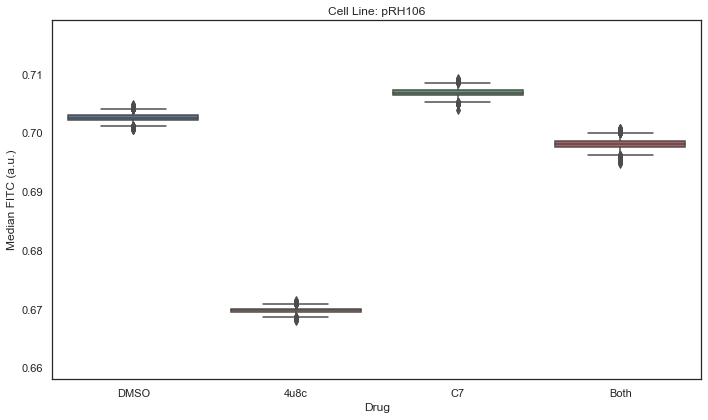

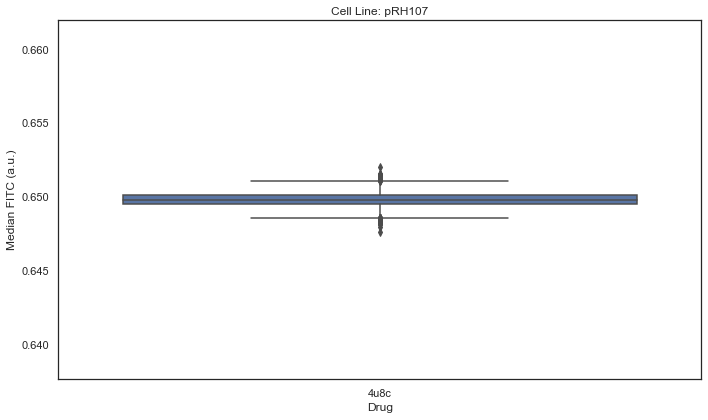

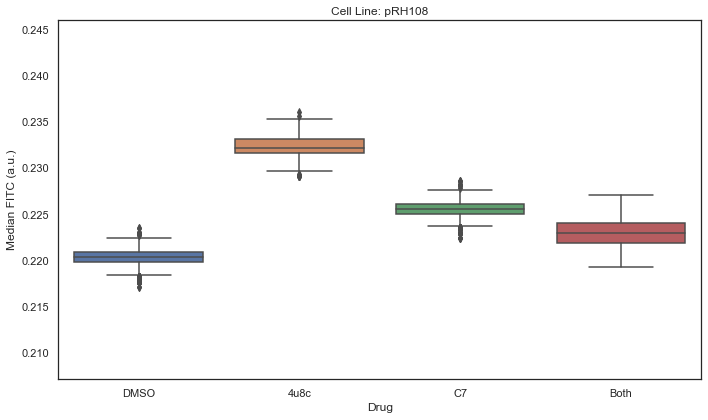

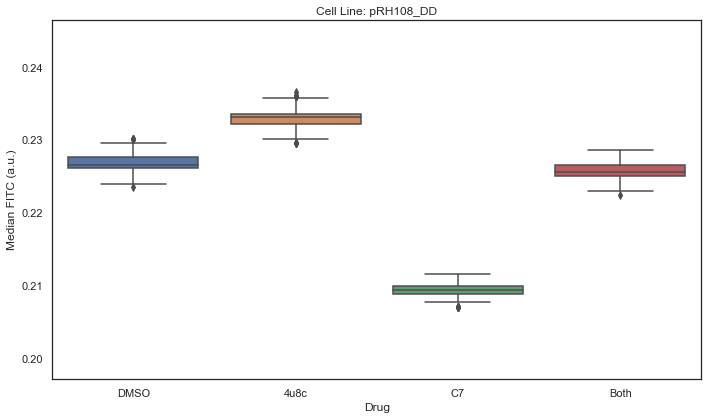

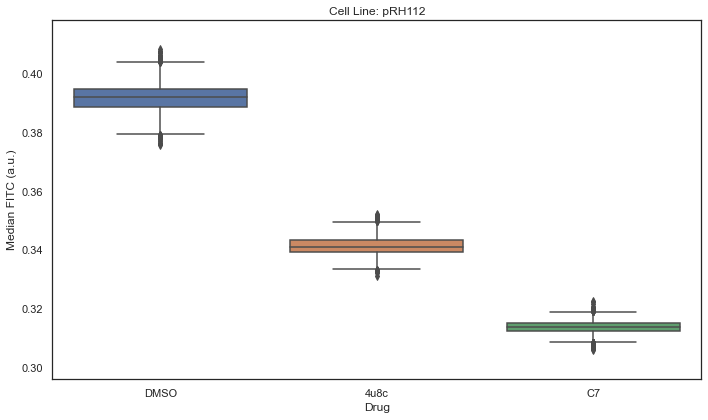

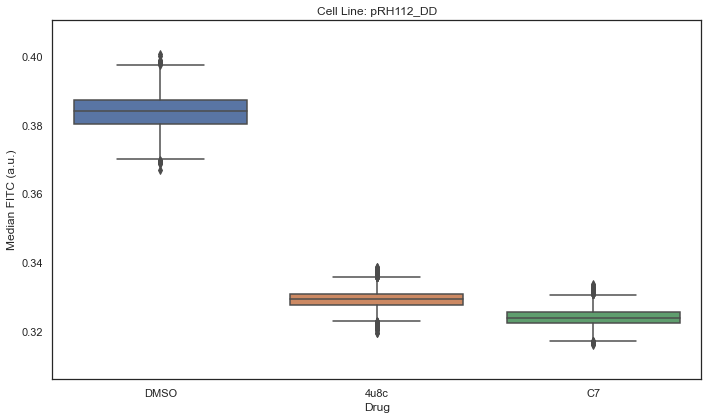

In [16]:
# Setting Seaborn style
sns.set(style="white")

# Preparing data for plotting
plot_data = []
for (cell_line, drug), medians in bootstrapped_results.items():
    for median in medians:
        plot_data.append({'Cell Line': cell_line, 'Drug': drug, 'Median': median})

df_plot = pd.DataFrame(plot_data)

# Unique cell lines
cell_lines = sorted(set(df_plot['Cell Line']))

# Loop over each cell line to create a separate plot
for cell_line in cell_lines:
    plt.figure(figsize=(10, 6))
    ax = sns.boxplot(x='Drug', y='Median', data=df_plot[df_plot['Cell Line'] == cell_line])
    plt.title(f'Cell Line: {cell_line}', pad=5)
    plt.xlabel('Drug')
    plt.ylabel('Median FITC (a.u.)')
    
    # Calculate min and max of the 'Median' values for the current cell line
    cell_line_data = df_plot[df_plot['Cell Line'] == cell_line]['Median']
    min_val, max_val = cell_line_data.min(), cell_line_data.max()
    plt.ylim(min_val - 0.01, max_val + 0.01)  # Set y-axis limits

    plt.xticks()  # Rotate drug labels for clarity

    # Save the plot as a PNG file
    #lt.savefig(f'{cell_line}_plot.png', bbox_inches='tight')
    
    plt.tight_layout()
    plt.show()
    
    plt.close()
